In [1]:
!sudo -H pip3 install numpy==1.17.4
!sudo -H pip3 install pycocotools

     |████████████████████████████████| 20.0MB 1.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4


# Pytorch starter - FasterRCNN Train
 
* The competition gives us bounding boxes that are in COCO format: (x-top left, y-top left, width, height). We convert it to Pascal VOC format: (x-top left, y-top left, x-bottom right, y-bottom right).

* Input to Albumentations transformer should be an image with pixels range between 0 & 255. Hence normalization of pixels has to be a part of transformation pipeline, specifically at the end. 


```

**Before (Notice np.float32)**

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

**Changed To**

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
#image /= 255.0

# Add Normalize transfomration at the end in the below function
def get_train_transform():
  return A.Compose([
        A.HorizontalFlip(1),
        A.RandomBrightness(0.5, p=1),
        A.RGBShift(p=1),
        #A.RandomGamma(gamma_limit=180, p=1),
        #A.Normalize(mean=0, std=1, max_pixel_value=255.0, always_apply=True, p=1.0),
        ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=0, std=1, max_pixel_value=255.0, always_apply=True, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

```

## Things to check before training the model

* Number of epochs - 30
* Size of train and valid data - 300 
* DataLoader -> Train - Shuffle = True
* Albumentation probabilities eg: RandomHorizontalFlip(0.5)
* Size of image passed to training (3 - 512 - 512)
* Kaggle LB score - 0.6115

## Options to improve

* Try different backbone
* Train more (I trained 30 epochs only)
* Use larger images (I rescaled to 512 during train/inference)
* More augmentations (I added only random flip for now)
* Optimize (loss, box-selection threshold, etc)
* Different anchor configuration (See torchvision's AnchorGenerator)
etc.


## 1) Data Preparation

In [2]:
# Mount google drive

from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import random, math
from ast import literal_eval
print(np.__version__)
from PIL import Image

# !pip install -U git+https://github.com/albumentations-team/albumentations.git
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/content/gdrive/My Drive/Object Detection' #input directory path
DIR_TRAIN = f'{DIR_INPUT}/train' #train images folder path
DIR_TEST = f'{DIR_INPUT}/test' #test images folder path

1.17.4


In [0]:
# Run this cell & Restart runtime 
#!pip install -U git+https://github.com/albumentations-team/albumentations.git

In [0]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv') #read the .csv file containing image ids and bounding boxes

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

# "+" 1 or more repetitions, "*" 0 or more repetitions, "?" 0 or 1 repetitions, "{m}" exactly m repetitions
def expand_bbox(x):
  r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
  if len(r) == 0:
      r = [-1, -1, -1, -1]
  return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
train_ids = image_ids[:-300] # image_ids[:-300]
valid_ids = image_ids[-300:] # image_ids[-300:]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

## 2) Visualize Data

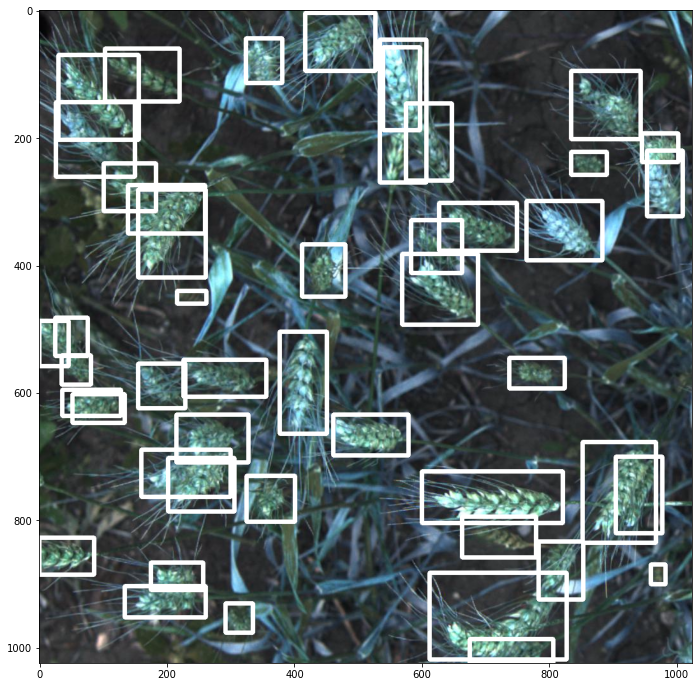

In [4]:
def get_img_bboxes(image_dir, image_id):

  img = cv2.imread(f'{image_dir}/{image_id}.jpg')

  # get all bboxes for given image in [xmin, ymin, width, height]
  bboxes = [literal_eval(box) for box in train_df[train_df['image_id'] == image_id]['bbox']]
  bboxes = np.array(bboxes)

  # convert from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax] before plotting
  bboxes[:,2] = bboxes[:,0] + bboxes[:,2]
  bboxes[:,3] = bboxes[:,1] + bboxes[:,3]

  return img, bboxes

def draw_rect(img, bboxes, color = None):
  """
  Draw the rectangle on the image
  
  Input:
  
  img (numpy.ndarray) - Numpy image 
  
  boxes (numpy.ndarray) - Numpy array containing bounding boxes of shape `N X 4` where N is the
                          number of bounding boxes and the bounding boxes are represented in the
                          format `x1 y1 x2 y2`
  """  

  img = img.copy()

  bboxes = bboxes.reshape(-1,4)
  if not color:
      color = [255,255,255]
  for bbox in bboxes:
      
      pt1, pt2 = (bbox[0], bbox[1]) , (bbox[2], bbox[3])
              
      pt1 = int(pt1[0]), int(pt1[1])
      pt2 = int(pt2[0]), int(pt2[1])
  
      img = cv2.rectangle(img.copy(), pt1, pt2, color, int(max(img.shape[:2])/200))
  
  plt.figure(figsize = (12,12))
  plt.imshow(img)

img, bboxes = get_img_bboxes(image_dir = DIR_TRAIN, image_id = 'b6ab77fd7')
draw_rect(img, bboxes)

## 3) Defining the Dataset

The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation.

https://github.com/ultralytics/yolov3/blob/master/utils/datasets.py

https://arxiv.org/pdf/1708.04552.pdf

In [0]:
from sklearn.utils import shuffle
import random
class WheatDataset(Dataset):

  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()
    
    self.df = dataframe
    self.image_ids = dataframe['image_id'].unique()
    self.image_ids = shuffle(self.image_ids)
    self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.image_ids)
    self.img_size = 1024
    im_w = 1024
    im_h = 1024
    for i, img_id in enumerate(self.image_ids):
      records = self.df[self.df['image_id'] == img_id]
      boxes = records[['x', 'y', 'w', 'h']].values
      boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
      boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
      boxesyolo = []
      for box in boxes:
        x1, y1, x2, y2 = box
        xc, yc, w, h = 0.5*x1/im_w+0.5*x2/im_w, 0.5*y1/im_h+0.5*y2/im_h, abs(x2/im_w-x1/im_w), abs(y2/im_h-y1/im_h)
        boxesyolo.append([0, xc, yc, w, h])
      self.labels[i] = np.array(boxesyolo)
    
    self.image_dir = image_dir
    self.transforms = transforms
    
    self.mosaic = False
    self.augment = True

  def __getitem__(self, index: int):

    
    #img, labels = load_mosaic(self, index)
    self.mosaic = True
    if random.randint(0,1) == 0:
      self.mosaic = False
    if self.mosaic:
      # Load mosaic
      img, labels = load_mosaic(self, index)
      shapes = None

    else:
      # Load image
      img, (h0, w0), (h, w) = load_image(self, index)

      # Letterbox
      shape = self.img_size  # final letterboxed shape
      img, ratio, pad = letterbox(img, shape, auto=False, scaleup=self.augment)
      shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling

      # Load labels
      labels = []
      x = self.labels[index]
      if x.size > 0:
        # Normalized xywh to pixel xyxy format
        labels = x.copy()
        labels[:, 1] = ratio[0] * w * (x[:, 1] - x[:, 3] / 2) + pad[0]  # pad width
        labels[:, 2] = ratio[1] * h * (x[:, 2] - x[:, 4] / 2) + pad[1]  # pad height
        labels[:, 3] = ratio[0] * w * (x[:, 1] + x[:, 3] / 2) + pad[0]
        labels[:, 4] = ratio[1] * h * (x[:, 2] + x[:, 4] / 2) + pad[1]
    
    if self.augment:
      # Augment imagespace
      if not self.mosaic:
        img, labels = random_affine(img, labels,
                                    degrees=0,
                                    translate=0,
                                    scale=0,
                                    shear=0)

      # Augment colorspace
      augment_hsv(img, hgain=0.0138, sgain= 0.678, vgain=0.36)
    
    # boxes (FloatTensor[N, 4]): coordinates of the N bounding boxes in [xmin, ymin, xmax, ymax] format 
    boxes = labels[:,[1,2,3,4]]
    boxes = torch.tensor(boxes, dtype=torch.float32)

    # area (Tensor[N]): area of the bounding box. 
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype=torch.float32)

    # labels (Int64Tensor[N]): the label for each bounding box
    # there is only one class
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64) 
    
    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64) 
    
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    # target['masks'] = None
    target['image_id'] = torch.tensor([index])
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }
      sample = self.transforms(**sample)

    img = sample['image']
    img = torch.tensor(img, dtype=torch.float32)

    boxes = sample['bboxes']
    target['boxes'] = torch.tensor(boxes, dtype=torch.float32)

    # area (Tensor[N]): area of the bounding box. 
    area = (target['boxes'][:, 3] - target['boxes'][:, 1]) * (target['boxes'][:, 2] - target['boxes'][:, 0])
    target['area'] = torch.as_tensor(area, dtype=torch.float32)

    return img, target

  def __len__(self) -> int:
    return self.image_ids.shape[0]

In [0]:
#dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())  
#im = dataset[0][0]
#tar = dataset[0][1]

In [0]:
#im

In [0]:
#tar

In [0]:
def load_image(self, index):
  # loads 1 image from dataset, returns img, original hw, resized hw
  image_id = self.image_ids[index]
  imgpath = DIR_TRAIN
  img = cv2.imread(f'{imgpath}/{image_id}.jpg', cv2.IMREAD_COLOR)
  
  assert img is not None, 'Image Not Found ' + imgpath
  h0, w0 = img.shape[:2]  # orig hw
  return img, (h0, w0), img.shape[:2]  # img, hw_original, hw_resized

In [0]:
def load_mosaic(self, index):
  # loads images in a mosaic

  labels4 = []
  s = self.img_size
  xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
  indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
  for i, index in enumerate(indices):
    # Load image
    img, _, (h, w) = load_image(self, index)

    # place img in img4
    if i == 0:  # top left
      img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
      x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
      x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif i == 1:  # top right
      x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
      x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif i == 2:  # bottom left
      x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
      x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif i == 3:  # bottom right
      x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
      x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
    padw = x1a - x1b
    padh = y1a - y1b

    # Labels
    x = self.labels[index]
    labels = x.copy()
    if x.size > 0:  # Normalized xywh to pixel xyxy format
      labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
      labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
      labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
      labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
    labels4.append(labels)

  # Concat/clip labels
  if len(labels4):
    labels4 = np.concatenate(labels4, 0)
    # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
    np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

  # Augment
  # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
  img4, labels4 = random_affine(img4, labels4,
                                degrees=1.98 * 2,
                                translate=0.05 * 2,
                                scale=0.05 * 2,
                                shear=0.641 * 2,
                                border=-s // 2)  # border to remove

  return img4, labels4

In [0]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
  # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
  # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

  if targets is None:  # targets = [cls, xyxy]
    targets = []
  height = img.shape[0] + border * 2
  width = img.shape[1] + border * 2

  # Rotation and Scale
  R = np.eye(3)
  a = random.uniform(-degrees, degrees)
  # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
  s = random.uniform(1 - scale, 1 + scale)
  R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

  # Translation
  T = np.eye(3)
  T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
  T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

  # Shear
  S = np.eye(3)
  S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
  S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

  # Combined rotation matrix
  M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
  if (border != 0) or (M != np.eye(3)).any():  # image changed
    img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

  # Transform label coordinates
  n = len(targets)
  if n:
    # warp points
    xy = np.ones((n * 4, 3))
    xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
    xy = (xy @ M.T)[:, :2].reshape(n, 8)

    # create new boxes
    x = xy[:, [0, 2, 4, 6]]
    y = xy[:, [1, 3, 5, 7]]
    xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

    # # apply angle-based reduction of bounding boxes
    # radians = a * math.pi / 180
    # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
    # x = (xy[:, 2] + xy[:, 0]) / 2
    # y = (xy[:, 3] + xy[:, 1]) / 2
    # w = (xy[:, 2] - xy[:, 0]) * reduction
    # h = (xy[:, 3] - xy[:, 1]) * reduction
    # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

    # reject warped points outside of image
    xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
    xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
    w = xy[:, 2] - xy[:, 0]
    h = xy[:, 3] - xy[:, 1]
    area = w * h
    area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
    ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
    i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

    targets = targets[i]
    targets[:, 1:5] = xy[i]

  return img, targets

In [0]:
def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
  r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
  hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
  dtype = img.dtype  # uint8

  x = np.arange(0, 256, dtype=np.int16)
  lut_hue = ((x * r[0]) % 180).astype(dtype)
  lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
  lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

  img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
  cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed

In [0]:
def letterbox(img, new_shape=(416, 416), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
  # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
  shape = img.shape[:2]  # current shape [height, width]
  if isinstance(new_shape, int):
    new_shape = (new_shape, new_shape)

  # Scale ratio (new / old)
  r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
  if not scaleup:  # only scale down, do not scale up (for better test mAP)
    r = min(r, 1.0)

  # Compute padding
  ratio = r, r  # width, height ratios
  new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
  dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
  if auto:  # minimum rectangle
    dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
  elif scaleFill:  # stretch
    dw, dh = 0.0, 0.0
    new_unpad = new_shape
    ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

  dw /= 2  # divide padding into 2 sides
  dh /= 2

  if shape[::-1] != new_unpad:  # resize
    img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
  top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
  left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
  return img, ratio, (dw, dh)


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## 4) Albumentation helper functions


We add a little transformer function that enhances our training set by doing some basic data augmentation (horizontal flip of images). Transforms are common image transformations. They can be chained together using *Compose*.

https://pytorch.org/docs/stable/torchvision/transforms.html

**From Kaggle Notebook**

```
albumentation_list = [A.RandomSunFlare(p=1), A.RandomFog(p=1), 
A.RandomBrightness(p=1), A.RandomCrop(p=1,height = 512, width = 512),
A.Rotate(p=1, limit=30), A.RGBShift(p=1), A.RandomSnow(p=1), 
A.HorizontalFlip(p=1), A.VerticalFlip(p=1), 
A.RandomContrast(limit = 0.5,p = 1), 
A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
```

**From Albumentation Colab Notebook**

```
RandomBrightness(limit=1.7, p=0.5) - (0.3,2)
RandomGamma(gamma_limit=180, p=0.5)
RGBShift(r_shift_limit=(0,20), g_shift_limit=(0,20), b_shift_limit=(0,20), p=1)
VerticalFlip(p=0.5)
HorizontalFlip(p=0.5)
HueSaturationValue(hue_shift_limit=172, sat_shift_limit=20, val_shift_limit=27, p=0.5)
RandomContrast(limit=0.9, p=0.5)
Normalize(mean=0, std=1, max_pixel_value=255.0, always_apply=True, p=1.0)
```






In [0]:
'''
from torchvision import transforms as T
def get_train_transform():
  return T.Compose([T.ToTensor()])

def get_valid_transform():
    return T.Compose([T.ToTensor()])
'''

'\nfrom torchvision import transforms as T\ndef get_train_transform():\n  return T.Compose([T.ToTensor()])\n\ndef get_valid_transform():\n    return T.Compose([T.ToTensor()])\n'

In [0]:
# Albumentations
def get_train_transform():
    return A.Compose([    
        A.Resize(height=512, width=512, p=1),
        A.HorizontalFlip(p=0.2),
        A.RandomBrightnessContrast(brightness_limit=(0,0.3), contrast_limit=(0,0.3), p=0.3),
        #A.RGBShift(p=0.2),
        #ValueError: Requested crop size (600, 600) is larger than the image size (512, 512)
        #A.RandomSizedCrop(min_max_height=(600,600), height=1024, width=1024, p=0.35),
        #A.RandomSizedCrop(min_max_height=(350,350), height=512, width=512, p=0.35),
        #A.RandomGamma(gamma_limit=180, p=1),
        A.ToSepia(always_apply=False, p=0.05),
        A.Normalize(mean=0, std=1, max_pixel_value=255.0, always_apply=True, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=0, std=1, max_pixel_value=255.0, always_apply=True, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## 5) Create the model

There are two common situations where one might want to modify one of the available models in torchvision. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example). Here we will finetune from a pretrained model.

In [12]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## 6) Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

https://pytorch.org/docs/stable/data.html

In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

# use our dataset and defined transformations
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())  
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())    

train_data_loader = DataLoader(train_dataset,
                               batch_size=16,
                               shuffle=True, # Change to True
                               num_workers=0, # Was initially set to 4
                               collate_fn=collate_fn)

valid_data_loader = DataLoader(valid_dataset,
                               batch_size=8,
                               shuffle=False,
                               num_workers=0,
                               collate_fn=collate_fn)

## 7) Transformation Check

In [0]:
fig, ax = plt.subplots(15, 1, figsize=(20, 160))
images, targets = next(iter(train_data_loader))
for i in range(15):  
  boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
  sample = images[i].mul(255).permute(1,2,0).cpu().numpy().astype(np.uint8)

  for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), 220, 3)

  ax[i].imshow(sample)

plt.show()

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
#targets

In [0]:
sample = images[0].mul(255).permute(1,2,0).cpu().numpy().astype(np.uint8)
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

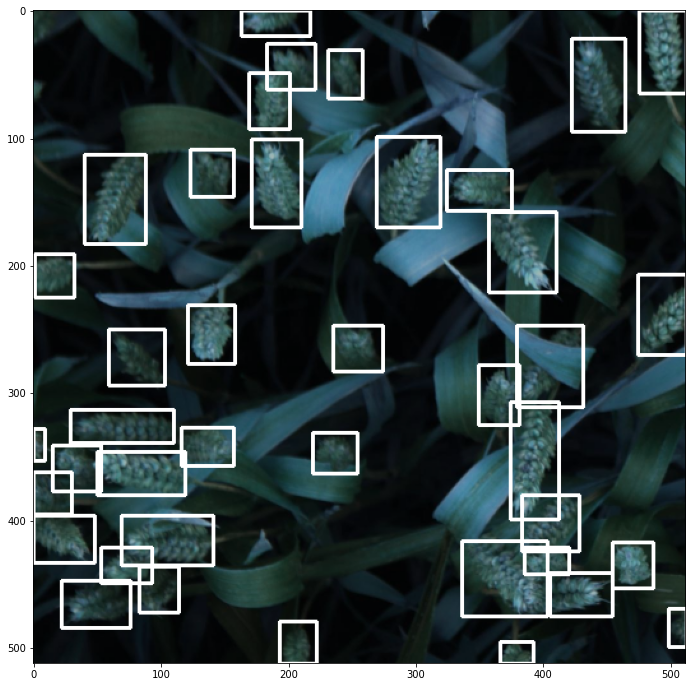

In [0]:
draw_rect(sample, boxes)

In [0]:
images, targets = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
sample = images[0].mul(255).permute(1,2,0).cpu().numpy().astype(np.uint8)
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

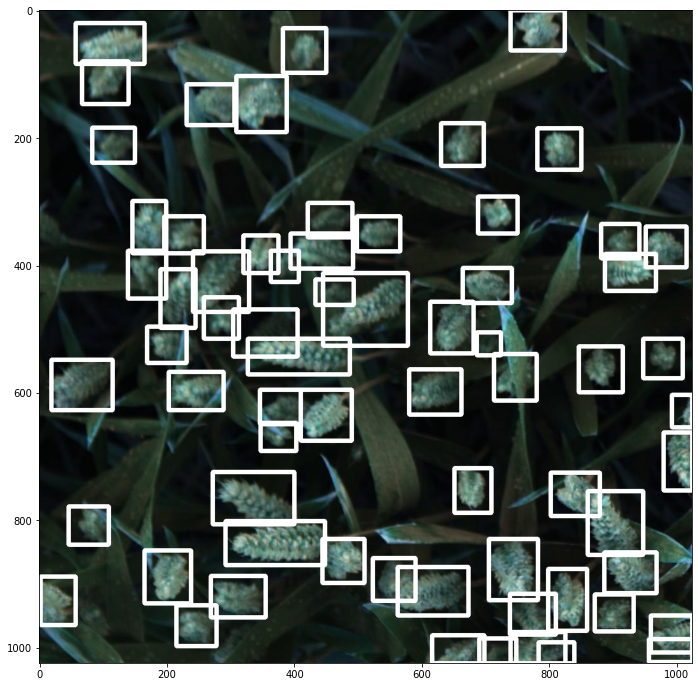

In [0]:
draw_rect(sample, boxes)

## 8) Train

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.005, 
                            momentum=0.9, 
                            weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils

In [0]:
# let's train it for 10 epochs
# https://github.com/pytorch/pytorch/issues/16417
num_epochs = 10

# RuntimeError: Expected object of scalar type double but got scalar type float for argument 'other'
# https://github.com/pytorch/vision/issues/1027
for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, valid_data_loader, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor

Epoch: [0]  [  0/193]  eta: 1:29:11  lr: 0.000031  loss: 5.3719 (5.3719)  loss_classifier: 0.8404 (0.8404)  loss_box_reg: 0.3298 (0.3298)  loss_objectness: 3.9572 (3.9572)  loss_rpn_box_reg: 0.2445 (0.2445)  time: 27.7266  data: 24.4845  max mem: 10834
Epoch: [0]  [ 10/193]  eta: 1:16:05  lr: 0.000291  loss: 3.4155 (3.4693)  loss_classifier: 0.7193 (0.7053)  loss_box_reg: 0.3690 (0.3740)  loss_objectness: 2.1435 (2.1619)  loss_rpn_box_reg: 0.2243 (0.2281)  time: 24.9468  data: 21.7279  max mem: 11146
Epoch: [0]  [ 20/193]  eta: 1:11:14  lr: 0.000551  loss: 1.6452 (2.5751)  loss_classifier: 0.5517 (0.6258)  loss_box_reg: 0.4251 (0.4020)  loss_objectness: 0.4718 (1.3298)  loss_rpn_box_reg: 0.2063 (0.2175)  time: 24.5548  data: 21.2845  max mem: 11146
Epoch: [0]  [ 30/193]  eta: 1:04:19  lr: 0.000811  loss: 1.4527 (2.1892)  loss_classifier: 0.5050 (0.5733)  loss_box_reg: 0.4342 (0.4146)  loss_objectness: 0.3289 (0.9908)  loss_rpn_box_reg: 0.1996 (0.2105)  time: 22.9821  data: 19.6306  max

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


creating index...
index created!
Test:  [ 0/38]  eta: 0:01:00  model_time: 0.6961 (0.6961)  evaluator_time: 0.4903 (0.4903)  time: 1.5853  data: 0.3749  max mem: 11146
Test:  [37/38]  eta: 0:00:01  model_time: 0.6757 (0.6645)  evaluator_time: 0.4388 (0.4355)  time: 1.6131  data: 0.4834  max mem: 11146
Test: Total time: 0:01:01 (1.6089 s / it)
Averaged stats: model_time: 0.6757 (0.6645)  evaluator_time: 0.4388 (0.4355)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ Io

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Object Detection/w-10ep-mosaic.pth')

In [0]:
torch.save(model, '/content/gdrive/My Drive/Object Detection/m-10ep-mosaic.pth')

# References 

https://github.com/pytorch/tutorials/issues/78

http://seba1511.net/tutorials/beginner/data_loading_tutorial.html  

https://blog.paperspace.com/data-augmentation-for-bounding-boxes/

**Transformation helper functions**

https://github.com/pytorch/vision/tree/master/references/detection

```
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
```



In [0]:
#torch.save(model, '/content/gdrive/My Drive/Object Detection/m10ep-frcnn.pth')
#from google.colab import files

#files.download('test.pth')

**Notes on Regular Expressions:**

https://docs.python.org/2/library/re.html

```
'*'
Matches 0 or more repetitions of the preceding RE, as many repetitions as are possible. 

'+' 
Matches 1 or more repetitions of the preceding RE. 

'?'
Matches 0 or 1 repetitions of the preceding RE. 

{m}
Specifies that exactly m copies of the previous RE should be matched; fewer matches cause the entire RE not to match.
```